In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym

from table_maker import *
from functools import partial
from itertools import *
from math import ceil

import pickle

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [3]:
# front finding functions
def find_root_indices(ys):
    # roots can be identified as a sign change from one point to the next.
    # if the product of two consective points is negative, then the sign changed.
    # if the product is zero, then one of the two points is the root
    root_mask = (ys[:-1]*ys[1:] <= 0) & (ys[1:]!=0) # locate roots
    root_indices = np.arange(len(ys)-1)[root_mask] # extract indices
    
    assert len(root_indices)%2 == 0 # ensure that there are an even number of roots
    left_roots = [root for root in root_indices[::2]]
    right_roots = [root for root in root_indices[1::2]]      
    for left_root, right_root in zip(left_roots, right_roots):
        assert ys[left_root]<0  and 0<ys[left_root+1]
        assert 0<ys[right_root] and ys[right_root+1]<0
    return root_indices

def refine_root(root_index, xs, ys, h, spatial_order):
    assert spatial_order >= 1
    if spatial_order == 1:
        return xs[root_index]
    # otherwise, interpolate and root-find
    stencil_size = spatial_order + 1
    half_stencil_size = stencil_size//2
    stencil = np.arange(  -half_stencil_size , -half_stencil_size + stencil_size)
    y_local = ys[root_index + stencil]
    coeffs = la.solve( np.array( [stencil**i for i in range(len(stencil))] ).T, y_local)

    my_f = lambda x: sum(c*x**i for (i,c) in enumerate(coeffs))
    d_coeffs = [i*c for (i,c) in enumerate(coeffs)][1:]
    my_df = lambda x: sum(c*x**i for (i,c) in enumerate(d_coeffs))

    my_root = 0
    for i in range(10):
        my_root -= my_f(my_root)/my_df(my_root)
    assert 0<= my_root and my_root <= 1 # interpolation failed
    return my_root*h + xs[root_index]

def refine_root_safe(root_index, xs, ys, h, spatial_order):
    try:
        root = refine_root(root_index, xs, ys, h, spatial_order)
    except:
        warnings.warn("Order %d interpolation failed. Reverting to Order 1 interpolation." % spatial_order)
        # linear interpolation will be safer
        root = refine_root(root_index, xs, ys, h, spatial_order=1)
    return root

def find_roots(xs, ys, h, spatial_order=4):
    return [ refine_root_safe(root_index, xs, ys, h, spatial_order=spatial_order) for root_index in  find_root_indices(ys) ]

$$\begin{align*}
    \mu u_t &= -u + w * f(u - a) \\
    \alpha a_t &= -a + \gamma f(u - a)
\end{align*}$$

In [4]:
with open('exp_diff_params.pickle', 'rb') as f:
    param_dict = pickle.load(f)
    globals().update(param_dict)
    
print(param_dict)

{'μ': 1, 'α': 5, 'γ': 3, 'θ': 0.1, 'm1': 3, 'm2': 1, 'σ1': 1, 'σ2': 2, 'c': 1.4206352135572324, 'Δ': 7.2672972146810135}


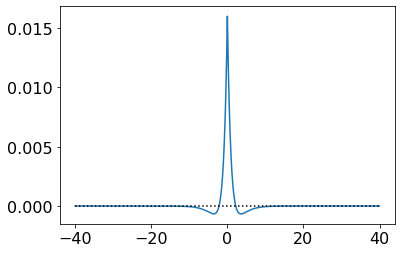

In [5]:
a, b = -30, 20
n = 10**4

###############################################
xs = np.linspace(a,b,n)
h = xs[1]-xs[0]

def firing_rate(u):
    return np.heaviside(u-θ, .5)

abs_x_sub_y = np.abs( np.subtract.outer(xs, xs) )
    
# exponetial
# M = .5*np.exp( - abs_x_sub_y ) * h

# exponetial difference
M1, M2 = m1, m2
M = (M1*np.exp(-abs_x_sub_y/σ1) - M2*np.exp(-abs_x_sub_y/σ2))*h

# decaying absolute value
# M = (1-abs_x_sub_y) * np.exp(-abs_x_sub_y) * h


plt.plot(xs, M[n//2])
plt.plot([a, b], [0, 0], 'k:')
# plt.xlim(-10, 10)
plt.show()

def RK4_step(F, t, u, dt):
    k1 = F(t,u)
    k2 = F(t+dt/2, u + dt/2*k1)
    k3 = F(t+dt/2, u + dt/2*k2)
    k4 = F(t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

def Euler_step(F, t, u, dt):
    return u + dt*F(t,u)

def F(t,u):
    temp = firing_rate(u[0] - u[1])
    ret = np.array([
        (-u[0] + M@temp)/μ,
        (-u[1] + γ*temp)/α
    ])
    return ret

In [6]:
def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

In [7]:
def Unum(ξ, μ, α, γ, θ, Δ, c, m1, σ1, m2, σ2):
    return (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(-np.exp((-Δ - ξ)/σ1) + np.exp(-ξ/σ1))/(μ*c + σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(np.exp((-Δ - ξ)/σ2) - np.exp(-ξ/σ2))/(μ*c + σ2))*(lambda input: np.heaviside(input,0.5))(ξ) + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(np.exp(ξ/σ1) - np.exp((Δ + ξ)/σ1))/(μ*c - σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(-np.exp(ξ/σ2) + np.exp((Δ + ξ)/σ2))/(μ*c - σ2) + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*(1 - np.exp(-Δ/σ1))/(μ*c - σ1) + m2*( lambda base, exponent: base**exponent )(σ2, 2)*(-1 + np.exp(-Δ/σ2))/(μ*c - σ2) + γ - γ*np.exp(-Δ/(α*c)) + θ)*np.exp(Δ/(μ*c))*np.exp(ξ/(μ*c)))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + (-m1*( lambda base, exponent: base**exponent )(σ1, 2)*np.exp((-Δ - ξ)/σ1)/(μ*c + σ1) + m1*( lambda base, exponent: base**exponent )(σ1, 2)*np.exp(ξ/σ1)/(μ*c - σ1) + 2*m1*σ1 + m2*( lambda base, exponent: base**exponent )(σ2, 2)*np.exp((-Δ - ξ)/σ2)/(μ*c + σ2) - m2*( lambda base, exponent: base**exponent )(σ2, 2)*np.exp(ξ/σ2)/(μ*c - σ2) - 2*m2*σ2 + (m1*( lambda base, exponent: base**exponent )(σ1, 2)*np.exp(-Δ/σ1)/(μ*c + σ1) - m1*( lambda base, exponent: base**exponent )(σ1, 2)/(μ*c - σ1) - 2*m1*σ1 - m2*( lambda base, exponent: base**exponent )(σ2, 2)*np.exp(-Δ/σ2)/(μ*c + σ2) + m2*( lambda base, exponent: base**exponent )(σ2, 2)/(μ*c - σ2) + 2*m2*σ2 + θ)*np.exp(ξ/(μ*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ)
def Anum(ξ, μ, α, γ, θ, Δ, c, m1, σ1, m2, σ2):
    return γ*(1 - np.exp(ξ/(α*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ) + γ*(np.exp(Δ/(α*c)) - 1)*np.exp(ξ/(α*c))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ)

with open('param_dict_exp_diff.pickle', 'rb') as f:
    numeric_params_dict = pickle.load(f)

In [9]:
u0 = np.zeros((2,n))

u0[0] = Unum(xs, **numeric_params_dict)
u0[1] = Anum(xs, **numeric_params_dict)

# u0[0] = cos_bell(xs, center=0, width=10)
# u0[0] = u_analytic(xs, M1, M2, σ)
# Δ = find_Delta(M1, M2, σ)
# u0[1] = γ * (np.heaviside(xs+Δ, .5) - np.heaviside(xs - Δ, .5))

I0 = .01
t_pulse = 1

t0 = 0
t_final = 5
k = 1e-4

my_step = Euler_step
# my_step = RK4_step

########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]
fronts = [find_roots(xs, u0[0]-u0[1]-θ, h, spatial_order=2)[-1]]

for step in range(steps):
    ts += [ts[-1] + k]
    new_u = my_step(F, ts[-1], us[-1], k)
    if abs(ts[-1] - t_pulse)/k < .5:
        new_u[0] += I0
    us += [ new_u ]
    fronts.append(find_roots(xs, us[-1][0]-us[-1][1]-θ, h, spatial_order=2)[-1])
    print(f'step {step}/{steps}', end='\r')

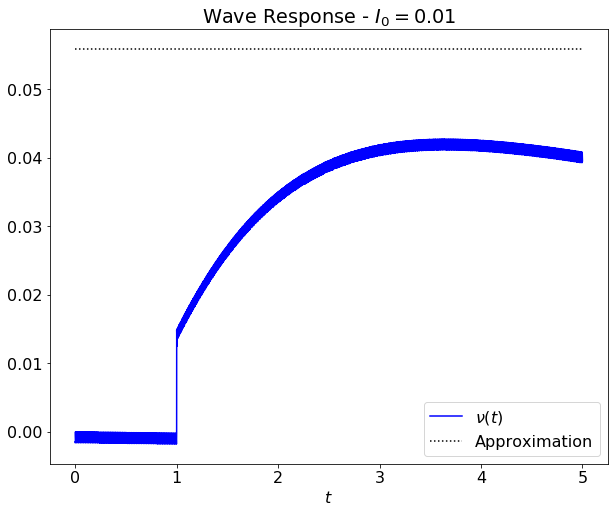

In [14]:
adjusted_fronts = [f - c*t for t, f in zip(ts, fronts)]
plt.figure(figsize=(10,8))
plt.plot(ts, adjusted_fronts, 'b-', label='$\\nu(t)$')
plt.plot( [ts[0], ts[-1]], [5.59261866714969*I0]*2, 'k:', label='Approximation')
plt.xlabel('$t$')
plt.legend()
plt.title(f'Wave Response - $I_0={I0}$')
plt.savefig('../reports/report20210819/wave_response.svg')
plt.show()

In [15]:
h

0.008000800080004922

(-0.06, 0.06)

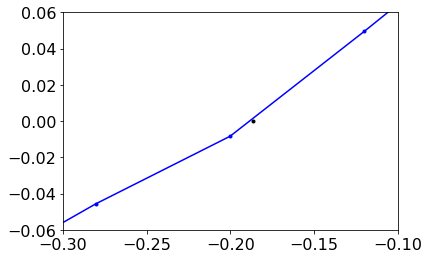

In [52]:
my_roots = find_roots(xs, us[-1][0] - us[-1][1] - θ, h, spatial_order=2)
plt.plot(xs, us[-1][0] - us[-1][1] - θ, 'b.-')
plt.plot(my_roots, [0]*2, 'k.')
plt.xlim(-.3, -.1)
plt.ylim(-.06, .06)

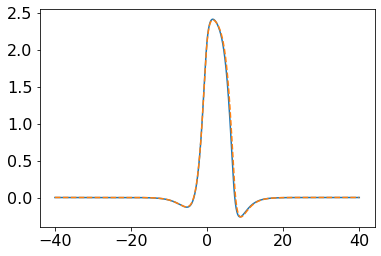

In [76]:
Utrue = Unum(xs-numeric_params_dict['c']*t_final, **numeric_params_dict)
plt.plot(xs, Utrue)
plt.plot(xs, us[-1][0], '--')
plt.show()

In [74]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

stride = 100

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# line_u_exact = ax[0].plot(xs, u_analytic(xs, M1, M2, σ), 'k:', label='$u_0$')
line_u, = ax[0].plot(xs, us[0][0], 'b-', label="$u$")
line_a, = ax[0].plot(xs, us[0][1], 'm-', label="$a$")

line_j, = ax[1].plot(xs, us[0][0]-us[0][1], 'g-', label='$J$')
ax[0].plot([xs[0], xs[-1]], [θ]*2, 'k:', label='$\\theta$')
ax[1].plot([xs[0], xs[-1]], [θ]*2, 'k:', label='$\\theta$')

ax[0].set_title(f'$w(x,y) = {M1}e^{{-|x-y|/{σ1}}} - {M2} e^{{-|x-y|/{σ2}}}$')

ax[0].legend(loc='right')
ax[1].legend(loc='right')
ax[0].set_ylim(*window)
# ax[0].set_ylim(-θ, 2*θ)
ax[0].set_xlim(a, b)

ax[1].set_ylim(-1.25, 1.1)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_a.set_ydata(us[i][1])
    line_j.set_ydata(us[i][0] - us[i][1])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('unstable.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())